# **Cars 4 You | Machine Learning Project**

### **Import Libraries**

In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from rapidfuzz import process, fuzz
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


### **Import Data**

In [461]:
df = pd.read_csv('../data/train.csv')

In [462]:
df_models = pd.read_csv('../data/car_models.csv')

---

### **Data Understanding**

In [463]:
df.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [464]:
df.describe(include='all')

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,74452,74456,74482.000000,75973.000000,74451,74510.000000,74462,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
unique,NaN,72,735,NaN,NaN,40,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ford,Focus,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,14808,6353,NaN,NaN,38050,NaN,37995,NaN,NaN,NaN,NaN,NaN,NaN
mean,37986.000000,NaN,NaN,2017.096611,16881.889553,NaN,23004.184088,NaN,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,21931.660338,NaN,NaN,2.208704,9736.926322,NaN,22129.788366,NaN,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,0.000000,NaN,NaN,1970.000000,450.000000,NaN,-58540.574478,NaN,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,18993.000000,NaN,NaN,2016.000000,10200.000000,NaN,7423.250000,NaN,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,NaN,NaN,2017.000000,14699.000000,NaN,17300.000000,NaN,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,NaN,NaN,2019.000000,20950.000000,NaN,32427.500000,NaN,145.000000,62.800000,2.000000,82.000000,3.000000,0.0


#### **Data Quality**
- **Price**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a slightly left skewed distribution
- **Mileage**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a left skewed distribution, we also have negative values, so we need to handle these values
- **Tax**: we have negative values, we need to investigate why these values are negative and If they make any sense in this context
- **MPG**: We have negative values, we need to handle these values
- **Engine Size**: We have negative values, needing to handle them
- **PaintQuality%**: We have values above 100%, we need to check this cases and see if they make any kind of sense
- **previousOwners**: We have negative and float values, we need to handle this cases as well
- **hasDamage**: Seems like a constant value feature, we need to check if thats the case


In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [466]:
# check for duplicates in car ID
df['carID'].nunique() == df.shape[0]

True

In [467]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

---

## **Data Preparation**

#### **Checking for constant value features**

In [468]:
# check for constant values features
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print(f'Constant features: {constant_features}')

Constant features: ['hasDamage']


Since hasDamage is a constant feature, we can safely remove it since theres no meaning if its keeped

In [469]:
df= df.drop(columns='hasDamage')

#### **Dealing with missing values**

First, lets check if we have any entries with every feature missing

In [470]:
# create a mask for rows where all columns except 'carID' and 'price' are NaN
mask = df.drop(columns=['carID', 'price']).isna().all(axis=1)
df_missing_rows = df[mask]

df_missing_rows.size

0

We don't have any row that is completely null

##### **Let's now check the percentages of missing values for each column**

In [471]:
# check the percentage of missing values for each column
missing_percent = df.isna().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
df_missing_percent = pd.DataFrame({'column': missing_percent.index, 'missing_percent': missing_percent.values})
df_missing_percent

,column,missing_percent
0,mpg,10.432654
1,tax,10.403696
2,previousOwners,2.040198
3,paintQuality%,2.005976
4,transmission,2.003343
5,Brand,2.002027
6,model,1.996762
7,engineSize,1.995446
8,fuelType,1.988864
9,year,1.962539


We have some percentage of missing values but nothing too bad.

#### **Fill Missing Values in Numeric Features**

For the numeric features, we will use KNN imputation with the 5 nearest neighbors and just set the weights to 'uniform'.

In [472]:
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']

In [473]:
# store mean and std
means = df[num_cols].mean()
stds = df[num_cols].std()

# normalize
df_scaled = (df[num_cols] - means) / stds

# impute on scaled data
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled),
    columns=num_cols,
    index=df.index
)

# inverse transform
df[num_cols] = df_imputed_scaled * stds + means

#### **Fill Missing Values in Categorical Features**

For the categorical variables we will use a Random Forest Classifier.  
We will train this RFC with the non null entries and use them to predict the null entries.  
We will do this sequentially in this order:  
Brand -> Model -> fuelType -> transmission

Since we believe thats the feature importance order.

In [474]:
def impute_categorical_rfc(df, target_col, ignore_cols=['carID', 'price'], n_estimators=200):
    """
    Impute missing values in a categorical column using a Random Forest Classifier.

    Parameters:
        df (pd.DataFrame): The dataframe containing missing values.
        target_col (str): Column to impute.
        ignore_cols (list): Columns to exclude from predictors.
        n_estimators (int): Number of trees for the Random Forest.

    Returns:
        pd.DataFrame: DataFrame with imputed column.
    """
    #split into rows with and without missing target
    df_notnull = df[df[target_col].notnull()]
    df_null = df[df[target_col].isnull()]

    #print(df_null.head())
    
    # predictors: list of all columns except target and ignored ones
    predictors = df.columns.drop([target_col] + ignore_cols)
    #print(predictors)
    
    #encode predictors, creates a column for every value of the target col and sets True/False for each row
    X_train = pd.get_dummies(df_notnull[predictors], drop_first=True)
    print(X_train)
    y_train = df_notnull[target_col]
    
    # train RFC
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    # predict missing
    if not df_null.empty:
        X_null = pd.get_dummies(df_null[predictors], drop_first=True)
        # we need to reindex the columns of X_null so we have the same columns as X_train
        # if therese a column in X_train that is not in X_null, we fill it with 0
        # if theres a column in X_null that is not in X_train, it will random guess
        X_null = X_null.reindex(columns=X_train.columns, fill_value=0)
        
        df.loc[df[target_col].isnull(), target_col] = rfc.predict(X_null)
    
    print(f"Imputed '{target_col}' using Random Forest with {len(X_train)} training rows.")
    return df

In [475]:
'''cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

for col in cat_cols:
    df = impute_categorical_rfc(df, col)'''


"cat_cols = ['Brand', 'model', 'fuelType', 'transmission']\n\nfor col in cat_cols:\n    df = impute_categorical_rfc(df, col)"

In [476]:
# save the filled dataframe to a csv file
#df.to_csv('../data/filled_cars.csv', index=False)

In [477]:
df = pd.read_csv('../data/filled_cars.csv')

---

### **Data Consistency**

**fixing brand and model typos**

In [478]:
# normalize strings: strip, lower
def clean_text(s):
    if pd.isna(s):
        return ''
    return str(s).strip().lower()

# normalize
df['brand_clean'] = df['Brand'].apply(clean_text)
df['model_clean'] = df['model'].apply(clean_text)
df_models['brand_clean'] = df_models['brand'].apply(clean_text)
df_models['model_clean'] = df_models['model'].apply(clean_text)
#print('Unique values for brand', df_models['brand_clean'].unique())


# --- fix models ---
def correct_model(row, df_models):
    model = row['model_clean']
    brand = row['brand_clean']
    
    if ((df_models['brand_clean'] == brand) & (df_models['model_clean'] == model)).any():
        return model
    
    if brand in df_models['brand_clean'].values:
        possible_models = df_models[df_models['brand_clean']==brand]['model_clean'].tolist()
        matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
        return matched_model if score >= 40 else model
    
    possible_models = df_models['model_clean'].tolist()
    matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
    return matched_model if score >= 40 else model

# --- fix brands ---
def correct_brand(row, df_models):
    brand = row['brand_clean']
    model = row['model_fixed']
    
    if brand in df_models['brand_clean'].values:
        return brand
    if model == 'unknown':
        return brand
    
    possible_brands = df_models[df_models['model_clean']==model]['brand_clean'].unique()
    #print("possible brands",possible_brands)
    if len(possible_brands) > 0:
        return possible_brands[0]
    
    all_brands = df_models['brand_clean'].unique()
    matched_brand, score = safe_extract_one(brand, all_brands, scorer=fuzz.token_sort_ratio)
    return matched_brand if score >= 40 else brand

# standard values in model
def standardize_model(s):
    if pd.isna(s):
        return ''
    s = str(s).lower().strip()
    s = s.replace('-', ' ')
    s = ' '.join(s.split())
    return s

def safe_extract_one(query, choices, scorer):
    result = process.extractOne(query, choices, scorer=scorer)
    if result is None:
        return None, 0
    # Algumas versões retornam 2 valores, outras 3
    if len(result) == 2:
        match, score = result
    elif len(result) == 3:
        match, score, _ = result
    else:
        match, score = result[0], result[1]
    return match, score



# standardize
df_models['model_clean'] = df_models['model'].apply(standardize_model)
df['model_clean'] = df['model'].apply(standardize_model)

# apply fix functions
df['model_fixed'] = df.apply(correct_model, axis=1, df_models=df_models)
df['brand_fixed'] = df.apply(correct_brand, axis=1, df_models=df_models)

# final resutl
df[['Brand', 'model', 'brand_fixed', 'model_fixed']]


# drop columns brand clean, model_clean, brand, model
df.drop(columns=['brand_clean', 'model_clean', 'Brand', 'model'], inplace= True)

df = df.rename(columns={'brand_fixed': 'brand', 'model_fixed': 'model'})

**fixing fuel type and transmission typos**

In [479]:
# Canonical values of fuel_type and transmission
canonical_fuels = ['petrol', 'diesel', 'hybrid', 'electric', 'other']
canonical_transmissions = ['manual', 'automatic', 'semi-auto', 'other']

# Normalize column strings
df['fuel_type_clean'] = (df['fuelType']
    .astype(str)
    .str.strip()
    .str.lower()
)
df['transmission_clean'] = (df['transmission']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Correcting typos in the columns
def fuzzy_match_column(series, canonical_values, score_cutoff=85, default='other'):
    """
    Fuzzy-matches each value in a pandas Series to a list of canonical values.
    Example:
        fuzzy_match_column(df['fuel_type_clean'], ['petrol', 'diesel', 'electric'])
    """
    def match_one(value):


        # exact match
        if value in canonical_values:
            return value

        # fuzzy match
        match = process.extractOne(value, canonical_values, scorer=fuzz.token_sort_ratio)
        if match is None:
            return "unknown"

        best_choice, score, _ = match
        return best_choice if score >= score_cutoff else default

    return series.apply(match_one)


# apply fix functions
df['fuel_type_fixed'] = fuzzy_match_column(df['fuel_type_clean'], canonical_fuels)
df['transmission_fixed'] = fuzzy_match_column(df['transmission_clean'], canonical_transmissions)


# final result
df[['fuelType', 'fuel_type_clean', 'fuel_type_fixed',
    'transmission', 'transmission_clean', 'transmission_fixed']].head(10)


# drop and rename
df.drop(columns= ['fuelType', 'fuel_type_clean', 'transmission','transmission_clean'], inplace= True)

df = df.rename(columns={'fuel_type_fixed': 'fuel_type', 'transmission_fixed': 'transmission'})

### **Duplicates**

First thing first, lets check if we have duplicate ids

In [480]:
df['carID'][df['carID'].duplicated()]

Series([], Name: carID, dtype: int64)

AS we see, theres no duplicated ids

In [481]:
df[df.duplicated(keep=False)]

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model,brand,fuel_type,transmission


No duplicated rows as well

### **Fix Column Names**

In [482]:
# change order of columns
df = df[['carID','brand', 'model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'price']]

In [483]:
# rename column cardid to car_id and brand fixed to brand
df = df.rename(columns={'carID': 'car_id', 'engineSize': 'engine_size', 'paintQuality%': 'paint_quality', 'previousOwners': 'previous_owners'})

In [484]:
df.head()

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
0,69512,volkswagen,golf,2016.0,semi-auto,28421.0,petrol,102.333851,11.417268,2.0,63.0,4.000000,22290
1,53000,toyota,yaris,2019.0,manual,4589.0,petrol,145.000000,47.900000,1.5,50.0,1.000000,13790
2,6366,audi,q3,2019.0,semi-auto,3624.0,petrol,145.000000,40.900000,1.5,56.0,4.000000,24990
3,29021,ford,fiesta,2018.0,manual,9102.0,petrol,145.000000,65.700000,1.0,50.0,-2.340306,12500
4,10062,bmw,2 series,2019.0,manual,1000.0,petrol,145.000000,42.800000,1.5,97.0,3.000000,22995


In [485]:
#Negative Values

In [486]:
columns_negative= ["previous_owners","mileage","mpg","engine_size","tax"]

# Apply abs function to each column in columns_negative
for col in columns_negative:
    df[col] = df[col].abs()

In [487]:
df[['mileage','paint_quality','year','previous_owners']] = (
    df[['mileage','paint_quality','year','previous_owners']]
    .round()
    .astype('Int64')   # allows missing values
)

In [488]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car_id           75973 non-null  int64  
 1   brand            75973 non-null  object 
 2   model            75973 non-null  object 
 3   year             75973 non-null  Int64  
 4   transmission     75973 non-null  object 
 5   mileage          75973 non-null  Int64  
 6   fuel_type        75973 non-null  object 
 7   tax              75973 non-null  float64
 8   mpg              75973 non-null  float64
 9   engine_size      75973 non-null  float64
 10  paint_quality    75973 non-null  Int64  
 11  previous_owners  75973 non-null  Int64  
 12  price            75973 non-null  int64  
dtypes: Int64(4), float64(3), int64(2), object(4)
memory usage: 7.8+ MB


---

### **Bivariate analysis**

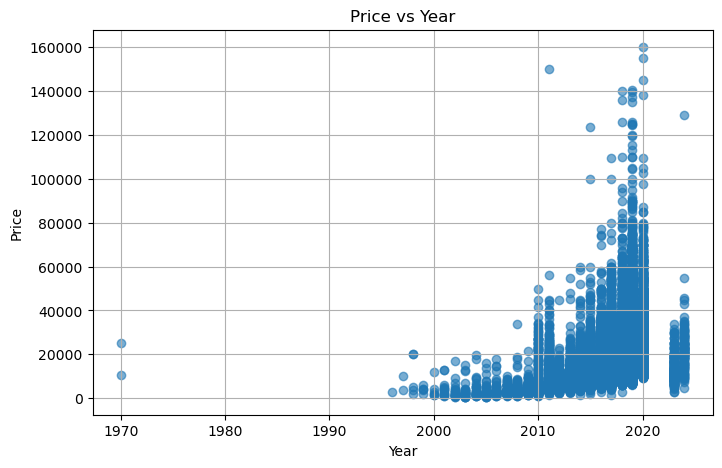

In [489]:
plt.figure(figsize=(8,5))
plt.scatter(df['year'], df['price'], alpha=0.6)
plt.title('Price vs Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### **Price vs year**
- newer cars (2016–2024) have much higher prices and wider spread, wwhich's normal
- older cars (before 2005) - a few have prices above £20,000–£40,000, which doesn’t make sense for old models.
- cars before 2012 are rare and might be not relevant for training
- **Drop cars with year < 2012**

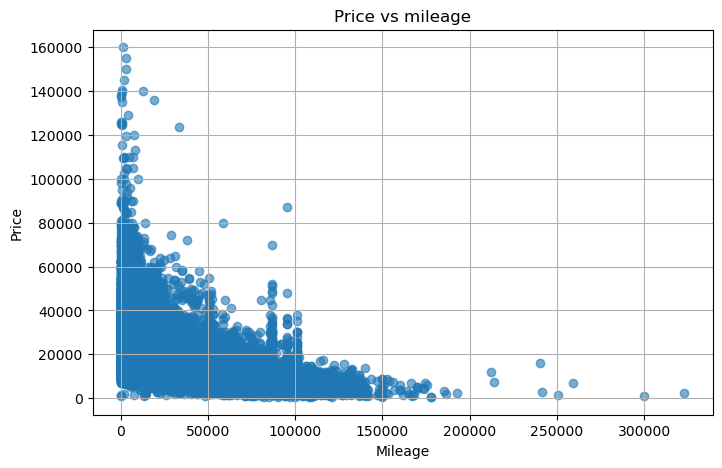

In [490]:
plt.figure(figsize=(8,5))
plt.scatter(df['mileage'], df['price'], alpha=0.6)
plt.title('Price vs mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### **Price vs mileage**
- negative correlation - higher mileage = lower price.
- A few low-mileage cars with very low prices → possible data entry errors
- A few high-mileage cars (>200,000–250,000 km) still priced high (>£30,000) - unrealistic unless special car models
- **mileage around 150,000–180,000 for normal cars. Values above are likely outliers**

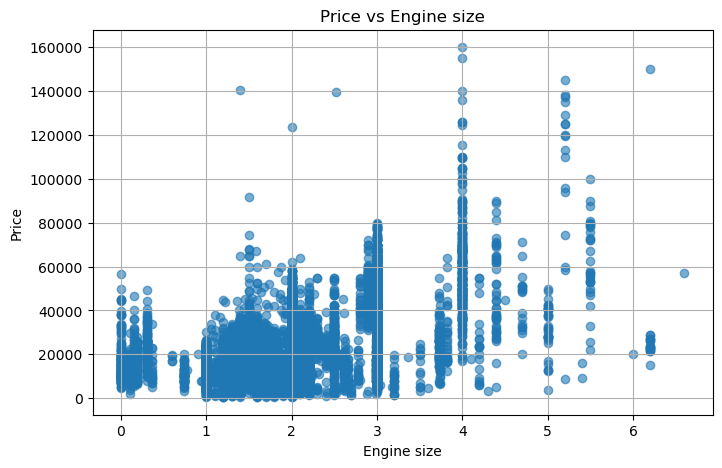

In [491]:
plt.figure(figsize=(8,5))
plt.scatter(df['engine_size'], df['price'], alpha=0.6)
plt.title('Price vs Engine size')
plt.xlabel('Engine size')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### **Price vs Engine Size**
- The majority of cars cluster between 1.0–2.5 L engines, with prices mostly below £40,000.
- A few points appear for engine_size > 4 L - these could be luxury or sports cars (high prices, rare models).
- Some at < 0.5 L could be data entry errors
- **Drop cars with engine_size < 0.5 or engine_size > 3.0. (Those outside the mainstream market range will distort model training.)**

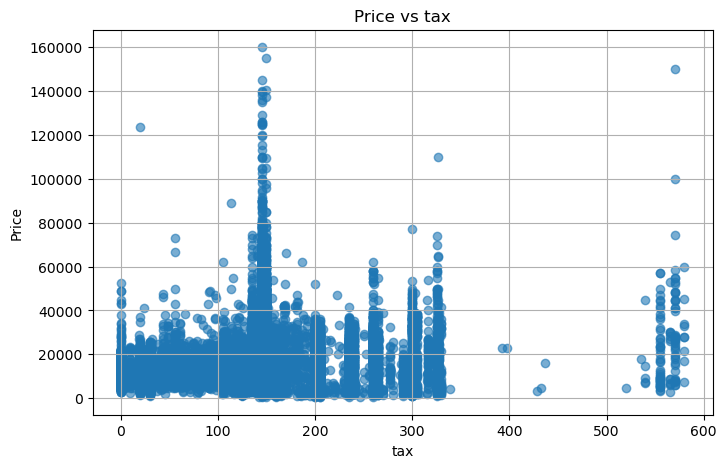

In [492]:
plt.figure(figsize=(8,5))
plt.scatter(df['tax'], df['price'], alpha=0.6)
plt.title('Price vs tax')
plt.xlabel('tax')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### **Price vs tax**
- We considered values of tax > 300 as outliers because they represent rare, high-performance or luxury vehicles that are not representative of the general car market and could skew model predictions.
- We kept values under 100 since they likely correspond to electric or low-emission cars with valid low tax rates, not errors.

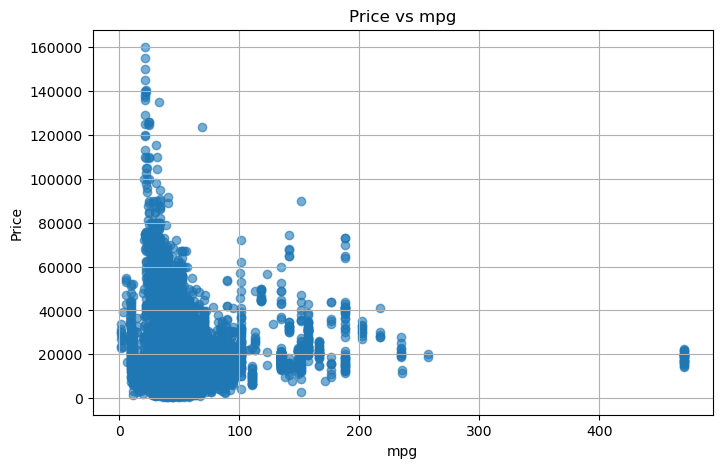

In [493]:
plt.figure(figsize=(8,5))
plt.scatter(df['mpg'], df['price'], alpha=0.6)
plt.title('Price vs mpg')
plt.xlabel('mpg')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### **Price vs mpg**
- Most data cluster around 30–70 mpg, with a reasonable downward slope (more mpg often → cheaper cars).
- A few cars show mpg > 100, even > 300–400 — those are likely data entry errors or hybrid-equivalent miscodings.
-  **we decided to remove cars with mpg > 80.**

---

### **Outliers**

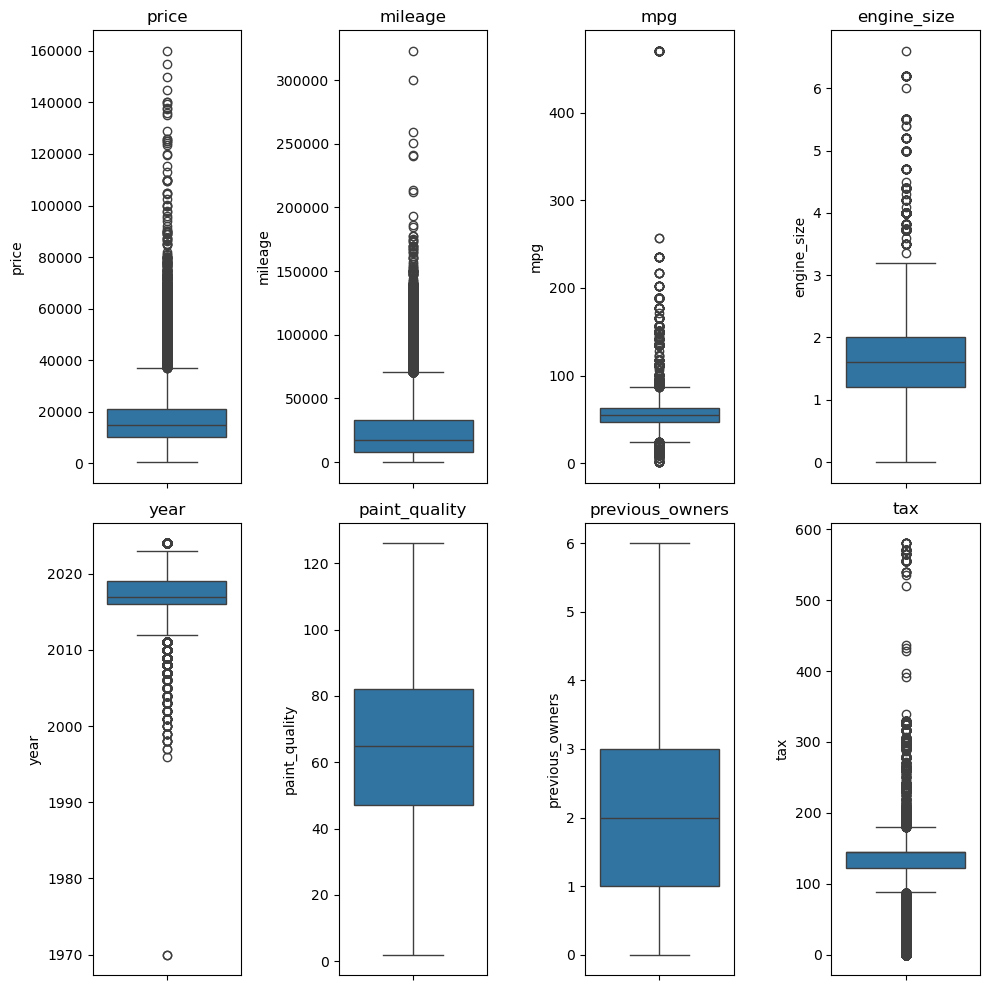

In [494]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()  # makes it a 1D array of length 6

sns.boxplot(df["price"], ax=axes[0])
axes[0].set_title("price")

sns.boxplot(df["mileage"], ax=axes[1])
axes[1].set_title("mileage")

sns.boxplot(df["mpg"], ax=axes[2])
axes[2].set_title("mpg")

sns.boxplot(df["engine_size"], ax=axes[3])
axes[3].set_title("engine_size")

sns.boxplot(df["year"], ax=axes[4])
axes[4].set_title("year")

sns.boxplot(df["paint_quality"], ax=axes[5])
axes[5].set_title("paint_quality")

sns.boxplot(df["previous_owners"], ax=axes[6])
axes[6].set_title("previous_owners")

sns.boxplot(df["tax"], ax=axes[7])
axes[7].set_title("tax")

plt.tight_layout()
plt.show()

1️⃣ price 

Observations: Most cars are clustered below ~40,000£, but there are numerous outliers above 50,000£, some exceeding 160,000£.
Interpretation: The dataset includes luxury or rare cars that are not typical — a right-skewed distribution.
Actionable insight:
Outliers may affect models sensitive to scale (like linear regression).
Could consider log-transforming price for regression models.
If predicting typical cars, consider capping extreme values or modeling separately.

2️⃣ mileage (miles traveled)
Observations: Majority of cars have mileage between ~5,000–50,000 miles. Some extreme high-mileage cars exceed 200,000 miles.
Interpretation: High-mileage cars are rare but present — right-skewed.
Insights:Could indicate older cars or heavy usage vehicles.
Extreme mileage outliers might distort models — consider log-transform or robust scaling.

3️⃣ mpg (Average Miles per Gallon)
Observations: Most cars cluster between 20–60 mpg, but some extreme outliers go above 400 mpg — likely data entry errors.
Insights:Values above ~100 mpg are unrealistic for standard cars → should be investigated and corrected or removed.
Could affect predictive modeling for fuel efficiency or price.

4️⃣ engineSize (liters)
Observations: Majority of engines are 1–3 liters. Outliers go beyond 5–6 liters.
Insights:Large engines (>5 L) are rare sports or luxury cars — aligns with high price outliers.
Outliers might be genuine, but check for misrecorded units.

5️⃣ year (Registration Year)
Observations: Most cars registered after 2005. Outliers below 1980, including one car around 1970.
Insights:Very old cars may be classic/collector cars → likely to have high price.
Could treat year as a numeric or categorical feature (modern vs. old cars) depending on the model.

6️⃣ paintQuality%
Observations: Values roughly span 0–125%, with most between 40–100%.
Could be a strong predictor of price or likelihood of damage.

7️⃣ previousOwners
Observations: Most cars have 1–3 previous owners. Few outliers have 6+ owners.
Insights:High owner counts are rare and could affect depreciation analysis.
Could treat as categorical or cap outliers at a reasonable max (e.g., 5).

In [495]:
df.shape

(75973, 13)

In [496]:
# --- Count outliers for each feature based on domain rules ---

mileage_outliers = (df["mileage"] > 180000).sum()   # Cars with >180,000 miles are atypical
mpg_outliers = (df["mpg"] > 80).sum()               # Unusually high fuel efficiency
engine_low_outliers = (df["engine_size"] < 0.5).sum()  # Unrealistically small engines
engine_high_outliers = (df["engine_size"] > 3.0).sum() # Large performance engines, rare
year_outliers = (df["year"] < 2012).sum()           # Cars older than 2012
tax_high_outliers = (df["tax"] > 300).sum()         # Unusually high tax values

# --- Display results ---
print("Outlier counts by feature:")
print(f"Mileage outliers (>150000): {mileage_outliers}")
print(f"MPG outliers (>80): {mpg_outliers}")
print(f"Engine size outliers (<0.5): {engine_low_outliers}")
print(f"Engine size outliers (>3.0): {engine_high_outliers}")
print(f"Year outliers (<2012): {year_outliers}")
print(f"Tax outliers (>300): {tax_high_outliers}")

Outlier counts by feature:
Mileage outliers (>150000): 11
MPG outliers (>80): 1479
Engine size outliers (<0.5): 518
Engine size outliers (>3.0): 654
Year outliers (<2012): 1668
Tax outliers (>300): 563


In [500]:
# --- Remove outliers based on domain rules ---

# Mileage: remove extremely high values
df = df[df["mileage"] <= 180000]

# MPG: remove unrealistically high fuel efficiency
df = df[df["mpg"] <= 80]

# Engine size: remove unrealistic small or large engines
df = df[(df["engine_size"] >= 0.5) & (df["engine_size"] <= 3.0)]

# Year: keep only cars newer than 2012
df = df[df["year"] >= 2012]

# Tax: remove very high tax values
df = df[df["tax"] <= 300]

# --- Display results ---
print(f"Cleaned dataset shape: {df.shape}")


Cleaned dataset shape: (71484, 13)


---

### **Correlations**

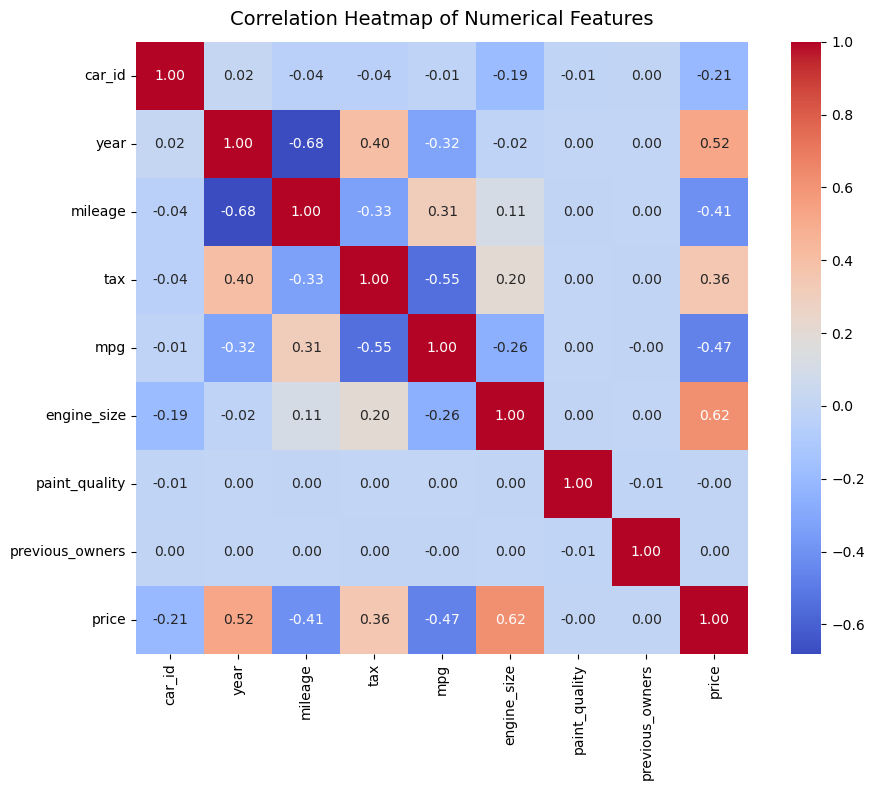

In [498]:
#only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])
# Computing correlation matrix ---
corr_matrix = numeric_df.corr()
# Plotting correlation heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14, pad=12)
plt.tight_layout()
plt.show()
target = 'price' 
# to identify top correlated features with the target
top_corr_features = corr_matrix[target].abs().sort_values(ascending=False).head(5).index.tolist()

#### **Target Correlation (Key Predictors)**
- engine_size, year, mileage, tax, and mpg have the strongest relationship with price.
-  **These should be primary input features for model training.**
#### **Low/No Correlation Features**
-  **paint_quality, previous_owners, car_id add noise and don’t help predict price.**

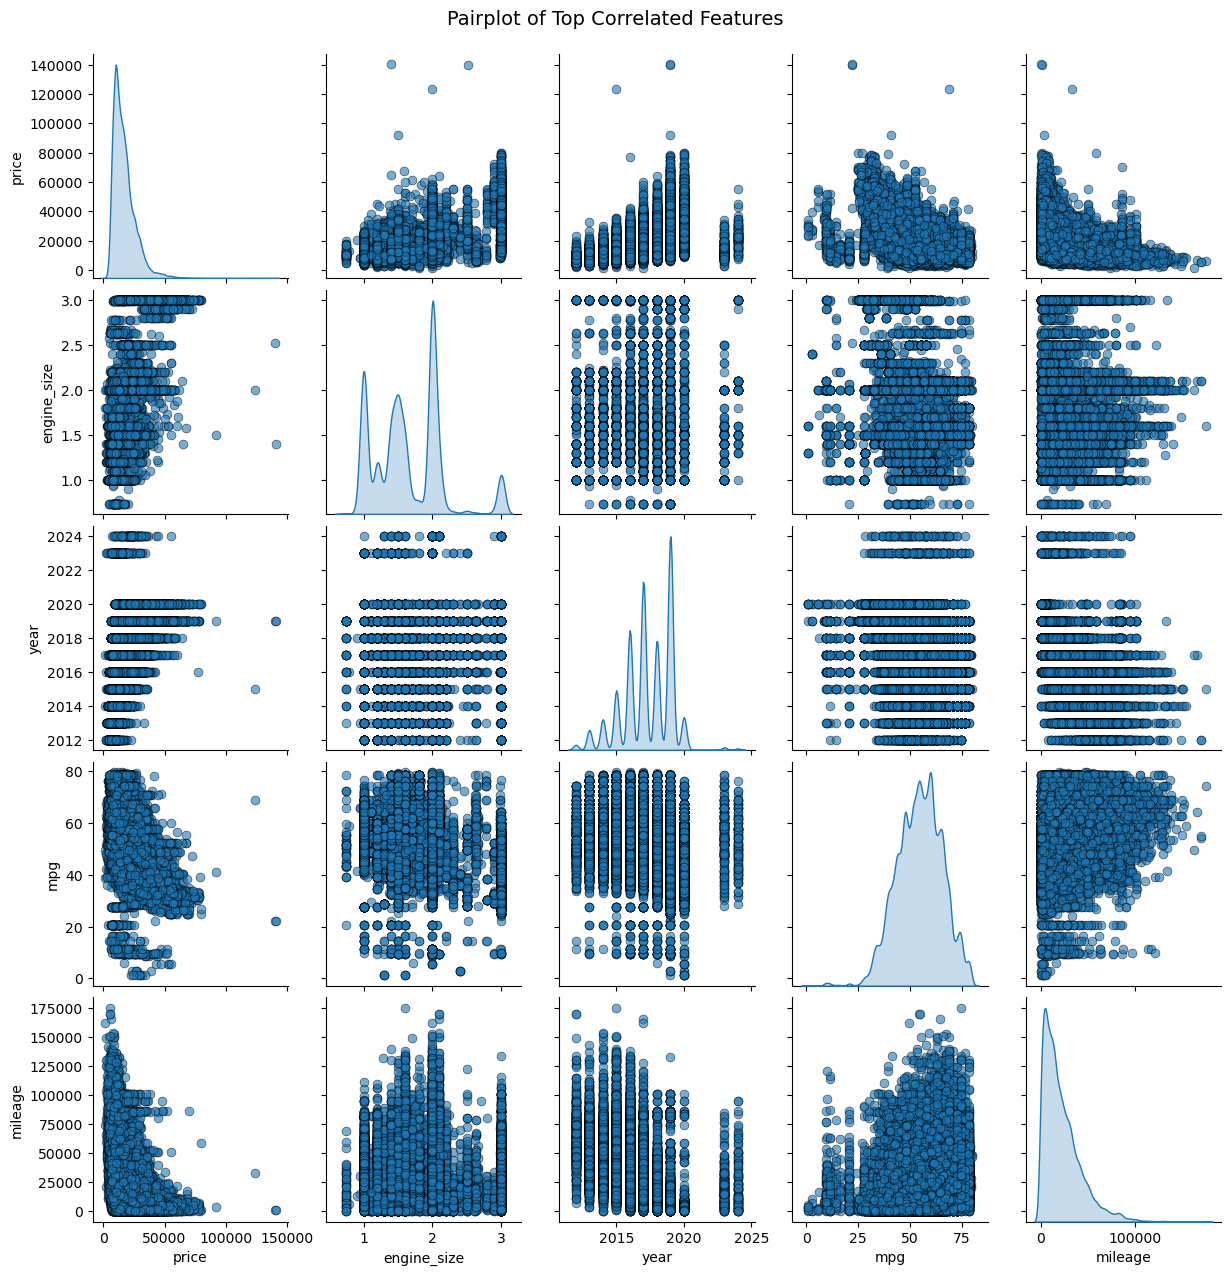

In [499]:
# a smaller DataFrame for pairplot
pairplot_df = df[top_corr_features]
# Plot pairplot
sns.pairplot(pairplot_df, diag_kind="kde", plot_kws={'alpha':0.6, 's':40, 'edgecolor':'k'})
plt.suptitle("Pairplot of Top Correlated Features", y=1.02, fontsize=14)
plt.show()

#### **Price vs Year**
- Clear positive relationship: newer cars (2020+) have higher prices.
✅ Strong predictor for price — probably among your top correlated features.
#### **Price vs Mileage**
-  Negative correlation — as expected, higher mileage = lower price.
✅ Another strong and intuitive predictor.
#### **Price vs Engine Size**
- Generally positive, but nonlinear: price increases up to ~2.5L, then scatters.
Suggests larger engines don’t always mean higher price — some luxury outliers remain.
#### **Price vs MPG**
-  Negative trend — higher MPG (fuel efficiency) often means cheaper cars.
✅ Makes sense: economy cars are more efficient but lower-priced.